In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from uszipcode import SearchEngine
from IPython.display import Image
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Linear Regression w/ l2 norm (Ridge)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Import Data
Get data from different sources before combining
* Cleaned up EV data: TX_WA_CO_NY.csv
* Average EV price and new car data over time: Avg_EV_Price.csv
* Census data (pop, household income, zipcode): census.csv 

In [16]:
# Import data
df_reg = pd.read_csv('./Data/TX_WA_CO_NY.csv')
df_ev = pd.read_csv('./Data/Avg_EV_Price.csv')
df_c = pd.read_csv('./Data/Census Data/census.csv')

# Convert dates to datetime dtype
df_reg['Registration Date'] = pd.to_datetime(df_reg['Registration Date'])
df_ev['Month'] = pd.to_datetime(df_ev['Month'], format='%b-%y')


# Merge Data
## Aggregate Registration Data by County

In [17]:
#Aggregate by County
# create a SearchEngine object
search = SearchEngine()

# define a function to map zip codes to counties
def zipcode_to_county(zipcode):
    #This county does not get populated for some reason
    if zipcode == 75033:
        return "Collin County"
    
    zipcode_data = search.by_zipcode(zipcode)
    county = zipcode_data.county
    return county

# apply the function to create a new column "County"
df_reg['County'] = df_reg['ZIP Code'].apply(zipcode_to_county)

KeyboardInterrupt: 

In [ ]:
df_reg.shape

(264426, 6)

In [ ]:
nan_rows = df_reg[df_reg.isna().any(axis=1)]

In [ ]:
df_reg = df_reg.groupby(["State", "Registration Date", "Drivetrain Type", "County"]).agg('sum').drop(columns = ["ZIP Code"]).reset_index()

start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2021-12-31')
df_reg = df_reg[(df_reg['Registration Date'] >= start_date) & (df_reg['Registration Date'] <= end_date)]

In [ ]:
df_reg[df_reg['County'] == ""]
df_reg.shape

(19398, 5)

## EV and New Car Prices

In [ ]:
# merge ev data in main df
df_reg_ev = pd.merge(df_reg, df_ev, left_on='Registration Date', right_on='Month', how='left')
df_reg_ev = df_reg_ev.drop(['Month'], axis=1)

# Since we don't have ev price data for earlier dates, set all NaN to price for 2020-01-01
fill_val = {'Average EV Price' : df_ev['Average EV Price'][0], 'New Car Average' : df_ev['New Car Average'][0]}
df_reg_ev = df_reg_ev.fillna(value=fill_val)

In [ ]:
# check if any nan values
nan_rows = df_reg_ev[df_reg_ev.isna().any(axis=1)]
nan_rows
df_reg_ev.shape

(19398, 7)

## Census Data

In [ ]:
# merge census data
df_reg_ev_c = pd.merge(df_reg_ev, df_c, left_on=['County', "State"], right_on=['county', 'state'], how='left')

df_reg_ev_c = df_reg_ev_c.drop(['Unnamed: 0', 'county'], axis=1)

# check if any nan values
nan_rows = df_reg_ev_c[df_reg_ev_c.isna().any(axis=1)]

print(nan_rows)

# Extract info of missing census data
print('Missing census data in:')
print('counties = ',nan_rows['County'].unique())
print('states = ',nan_rows['State'].unique())
print('Total num of countires = ',len(nan_rows['County'].unique()))
print('Total entries w/ nan = ', len(nan_rows))
#print('Total entries in df = ', len(df))

# The number of missing data is < 1% of total data, just drop
df_reg_ev_c = df_reg_ev_c.dropna()

df_reg_ev_c[['population', 'household_income']] = df_reg_ev_c[['population', 'household_income']].astype(int)


Empty DataFrame
Columns: [State, Registration Date, Drivetrain Type, County, Vehicle Count, Average EV Price, New Car Average, Unnamed: 0.1, population, household_income, state]
Index: []
Missing census data in:
counties =  []
states =  []
Total num of countires =  0
Total entries w/ nan =  0


In [ ]:
print(df_reg_ev_c.dtypes)

State                        object
Registration Date    datetime64[ns]
Drivetrain Type              object
County                       object
Vehicle Count                 int64
Average EV Price             object
New Car Average              object
Unnamed: 0.1                  int64
population                    int32
household_income              int32
state                        object
dtype: object


# Urban/Rural Divide
Source: https://www2.census.gov/geo/docs/reference/ua/2020_UA_COUNTY.xlsx 
Website: https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural.html

In [ ]:
county_pop_density = pd.read_excel("./Data/2020_UA_COUNTY.xlsx")#, sheet = "2020_UA_COUNTY")
county_pop_density['STATE_NAME']
def state_to_abbreviation(state):
    if state == 'Texas':
        return 'TX'
    elif state == 'New York':
        return 'NY'
    elif state == 'Colorado':
        return 'CO'
    elif state == 'Washington':
        return 'WA'
    else:
        return None # or whatever you want to return if the input is not a valid state name

county_pop_density["STATE_NAME"] = county_pop_density["STATE_NAME"].apply(state_to_abbreviation)

In [ ]:
county_pop_density_df = county_pop_density[["STATE_NAME","COUNTY_NAME", "POPDEN_COU"]]
county_pop_density_df['urban_flag'] = [1 if x > 500 else 0 for x in county_pop_density_df['POPDEN_COU']]
county_pop_density_df['COUNTY_NAME'] = county_pop_density_df['COUNTY_NAME'].apply(lambda x: x + ' County')
county_pop_density_df

C:\Users\markm\AppData\Local\Temp\ipykernel_19496\3497240639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_pop_density_df['urban_flag'] = [1 if x > 500 else 0 for x in county_pop_density_df['POPDEN_COU']]
C:\Users\markm\AppData\Local\Temp\ipykernel_19496\3497240639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_pop_density_df['COUNTY_NAME'] = county_pop_density_df['COUNTY_NAME'].apply(lambda x: x + ' County')


,STATE_NAME,COUNTY_NAME,POPDEN_COU,urban_flag
0,None,Autauga County,98.922916,0
1,None,Baldwin County,145.781265,0
2,None,Barbour County,28.500467,0
3,None,Bibb County,35.814001,0
4,None,Blount County,91.696680,0
...,...,...,...,...
3229,None,Yabucoa County,551.052867,1
3230,None,Yauco County,504.673516,1
3231,None,St. Croix County,491.862425,0
3232,None,St. John County,197.101643,0


In [ ]:
df_gas_elec_prices = pd.read_csv("./Data/electricity_gas_prices_reformatted.csv")

# Define a dictionary to map month names to numerical values
month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 
              'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08', 
              'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
urban_rural_dict = {"Urban" : 1.0, "Rural" : 0.0}

# Use the map() method to convert the "month" column to numerical values
df_gas_elec_prices['Month'] = df_gas_elec_prices['Month'].map(month_dict)

df_gas_elec_prices['urban_flag'] = df_gas_elec_prices['Population Type'].map(urban_rural_dict)


# Combine "year" and "month" columns into a new column in the format "YYYY-MM"
df_gas_elec_prices['year_month'] = df_gas_elec_prices['Year'].astype(str) + '-' + df_gas_elec_prices['Month']

# Convert the "year_month" column to a datetime object
df_gas_elec_prices['date'] = pd.to_datetime(df_gas_elec_prices['year_month'])


df_gas_elec_prices = df_gas_elec_prices.drop(columns = ["Unnamed: 0", "Population Type", "Year", 
                                            "Month", "year_month"])

df_gas_elec_prices


,State,Electricity Price,Gas Price,urban_flag,date
0,TX,10.490,2.139,0.0,2017-01-01
1,TX,10.490,2.083,0.0,2017-02-01
2,TX,10.490,2.089,0.0,2017-03-01
3,TX,10.490,2.195,0.0,2017-04-01
4,TX,10.490,2.187,0.0,2017-05-01
...,...,...,...,...,...
531,CO,0.157,3.691,1.0,2022-10-01
532,CO,0.152,3.429,1.0,2022-11-01
533,CO,0.152,2.979,1.0,2022-12-01
534,CO,0.153,3.479,1.0,2023-01-01


In [ ]:
df = pd.merge(df_reg_ev_c, county_pop_density_df, left_on=['State','County'], right_on=['STATE_NAME','COUNTY_NAME'], how='left')
df = pd.merge(df, df_gas_elec_prices, left_on = ["State", "urban_flag" ,"Registration Date"], right_on = ["State", "urban_flag", "date"], how = "left")
df = df.drop(columns = ["Unnamed: 0.1", "STATE_NAME", "COUNTY_NAME", "date", "urban_flag"])
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [State, Registration Date, Drivetrain Type, County, Vehicle Count, Average EV Price, New Car Average, population, household_income, state, POPDEN_COU, Electricity Price, Gas Price]
Index: []


In [ ]:
df

,State,Registration Date,Drivetrain Type,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price
0,CO,2017-01-01,BEV,Adams County,24,"$54,669","$38,747",509844,167290,CO,445.323695,12.66,3.378
1,CO,2017-01-01,BEV,Arapahoe County,65,"$54,669","$38,747",649980,241889,CO,821.038725,0.12,2.429
2,CO,2017-01-01,BEV,Boulder County,167,"$54,669","$38,747",324682,127365,CO,455.351666,12.66,3.378
3,CO,2017-01-01,BEV,Broomfield County,14,"$54,669","$38,747",69444,27199,CO,2248.011733,0.12,2.429
4,CO,2017-01-01,BEV,Denver County,94,"$54,669","$38,747",715878,287756,CO,4674.337363,0.12,2.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,WA,2021-12-01,PHEV,Wahkiakum County,6,"$63,821","$47,243",4318,1900,WA,16.818489,9.72,3.908
19394,WA,2021-12-01,PHEV,Walla Walla County,81,"$63,821","$47,243",60785,22773,WA,49.277735,9.72,3.908
19395,WA,2021-12-01,PHEV,Whatcom County,639,"$63,821","$47,243",224538,88978,WA,107.617198,9.72,3.908
19396,WA,2021-12-01,PHEV,Whitman County,56,"$63,821","$47,243",49577,18485,WA,22.217436,9.72,3.908


# Export Data

In [ ]:
# Desired prediction var
predict_label = 'Vehicle Count'

# Drop zip code since it would increase the number of features by ~4k
# also zip code is highly correlated to population and income
# Drop registration date since we will change to Unix timestamps
drop_col = ['state','County', 'Registration Date']

# Assemble Categorical Variables
cat_var = ['State', 'Drivetrain Type']
for cat in cat_var:
    # Get dummy variables for cat
    dummy_var = df[cat].unique()
    dummy_var = dummy_var[1:]

    # create df w/ one hot cat features
    df_cat = pd.get_dummies(df[cat], drop_first=True)

    # drop original
    df = df.drop([cat], axis=1)

    # concatenate
    df = pd.concat([df, df_cat], axis=1)

# Add Unix timestamp   
df['Unix Time'] = df['Registration Date'].apply(lambda x: x.timestamp())

# Convert $ price into integer
df['Average EV Price'] = df['Average EV Price'].str.replace('$','').str.replace(',','').astype(int)
df['New Car Average'] = df['New Car Average'].str.replace('$','').str.replace(',','').astype(int)

df

C:\Users\markm\AppData\Local\Temp\ipykernel_19496\3669364176.py:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Average EV Price'] = df['Average EV Price'].str.replace('$','').str.replace(',','').astype(int)
C:\Users\markm\AppData\Local\Temp\ipykernel_19496\3669364176.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['New Car Average'] = df['New Car Average'].str.replace('$','').str.replace(',','').astype(int)


,Registration Date,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,PHEV,Unix Time
0,2017-01-01,Adams County,24,54669,38747,509844,167290,CO,445.323695,12.66,3.378,0,0,0,0,1.483229e+09
1,2017-01-01,Arapahoe County,65,54669,38747,649980,241889,CO,821.038725,0.12,2.429,0,0,0,0,1.483229e+09
2,2017-01-01,Boulder County,167,54669,38747,324682,127365,CO,455.351666,12.66,3.378,0,0,0,0,1.483229e+09
3,2017-01-01,Broomfield County,14,54669,38747,69444,27199,CO,2248.011733,0.12,2.429,0,0,0,0,1.483229e+09
4,2017-01-01,Denver County,94,54669,38747,715878,287756,CO,4674.337363,0.12,2.429,0,0,0,0,1.483229e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,2021-12-01,Wahkiakum County,6,63821,47243,4318,1900,WA,16.818489,9.72,3.908,0,0,1,1,1.638317e+09
19394,2021-12-01,Walla Walla County,81,63821,47243,60785,22773,WA,49.277735,9.72,3.908,0,0,1,1,1.638317e+09
19395,2021-12-01,Whatcom County,639,63821,47243,224538,88978,WA,107.617198,9.72,3.908,0,0,1,1,1.638317e+09
19396,2021-12-01,Whitman County,56,63821,47243,49577,18485,WA,22.217436,9.72,3.908,0,0,1,1,1.638317e+09


In [ ]:
# Desired prediction var
predict_label = 'Vehicle Count'

# Get labels of all features
features = [c for c in df.columns if c not in [predict_label] + drop_col]
features
# extract values to np
y = df[predict_label].to_numpy()
X = df[features].to_numpy()

df = df.reset_index(drop=True)
df.to_csv('./Data/df_all_features_county.csv', index = False)
df[features].to_csv('./Data/df_X_county.csv', index = False)
df[predict_label].to_csv('./Data/df_y_county.csv', index = False)


# Add Fips and Predict both PHEV and BEV
Currently we have Vehicle Count we are predicting with a one hot vector for PHEV

However, we actually want to predict both of these values so we should have two columns per them

Essentially we have duplicate nodes that we need to get rid of for the GNN

In [ ]:
df = pd.read_csv('./Data/df_all_features_county.csv')
df

,Registration Date,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,PHEV,Unix Time,fips
0,2017-01-01,Adams County,24,54669,38747,509844,167290,CO,445.323695,12.66,3.378,0,0,0,0,1.483229e+09,8001
1,2017-01-01,Arapahoe County,65,54669,38747,649980,241889,CO,821.038725,0.12,2.429,0,0,0,0,1.483229e+09,8005
2,2017-01-01,Boulder County,167,54669,38747,324682,127365,CO,455.351666,12.66,3.378,0,0,0,0,1.483229e+09,8013
3,2017-01-01,Broomfield County,14,54669,38747,69444,27199,CO,2248.011733,0.12,2.429,0,0,0,0,1.483229e+09,8014
4,2017-01-01,Denver County,94,54669,38747,715878,287756,CO,4674.337363,0.12,2.429,0,0,0,0,1.483229e+09,8031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,2021-12-01,Wahkiakum County,6,63821,47243,4318,1900,WA,16.818489,9.72,3.908,0,0,1,1,1.638317e+09,53069
19394,2021-12-01,Walla Walla County,81,63821,47243,60785,22773,WA,49.277735,9.72,3.908,0,0,1,1,1.638317e+09,53071
19395,2021-12-01,Whatcom County,639,63821,47243,224538,88978,WA,107.617198,9.72,3.908,0,0,1,1,1.638317e+09,53073
19396,2021-12-01,Whitman County,56,63821,47243,49577,18485,WA,22.217436,9.72,3.908,0,0,1,1,1.638317e+09,53075


In [ ]:
state_list = df['state'].to_list()
county_list = df['County'].to_list()
county_state_list = [county_list[i] + ', ' + state_list[i] for i in range(len(state_list))]
county_state_list

['Adams County, CO',
 'Arapahoe County, CO',
 'Boulder County, CO',
 'Broomfield County, CO',
 'Denver County, CO',
 'Douglas County, CO',
 'Eagle County, CO',
 'El Paso County, CO',
 'Elbert County, CO',
 'Garfield County, CO',
 'Grand County, CO',
 'Gunnison County, CO',
 'Jefferson County, CO',
 'La Plata County, CO',
 'Larimer County, CO',
 'Las Animas County, CO',
 'Mesa County, CO',
 'Montrose County, CO',
 'Otero County, CO',
 'Park County, CO',
 'Pitkin County, CO',
 'Pueblo County, CO',
 'San Miguel County, CO',
 'Summit County, CO',
 'Weld County, CO',
 'Adams County, CO',
 'Alamosa County, CO',
 'Arapahoe County, CO',
 'Boulder County, CO',
 'Broomfield County, CO',
 'Delta County, CO',
 'Denver County, CO',
 'Douglas County, CO',
 'Eagle County, CO',
 'El Paso County, CO',
 'Elbert County, CO',
 'Garfield County, CO',
 'Gunnison County, CO',
 'Hinsdale County, CO',
 'Jefferson County, CO',
 'La Plata County, CO',
 'Lake County, CO',
 'Larimer County, CO',
 'Logan County, CO

In [ ]:
# Create a dictionary that maps the 'fruit' column of the DataFrame to the 'color' column
map_dict = dict(zip(df_a['countyname'], df_a['fipscounty']))

# Use the map() function to map the values in the list to the corresponding values in the DataFrame column
mapped_fips = list(map(lambda f: map_dict[f], county_state_list))
df['fips'] = mapped_fips
df.to_csv('./Data/df_all_features_county.csv', index = False)
df

,Registration Date,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,PHEV,Unix Time,fips
0,2017-01-01,Adams County,24,54669,38747,509844,167290,CO,445.323695,12.66,3.378,0,0,0,0,1.483229e+09,8001
1,2017-01-01,Arapahoe County,65,54669,38747,649980,241889,CO,821.038725,0.12,2.429,0,0,0,0,1.483229e+09,8005
2,2017-01-01,Boulder County,167,54669,38747,324682,127365,CO,455.351666,12.66,3.378,0,0,0,0,1.483229e+09,8013
3,2017-01-01,Broomfield County,14,54669,38747,69444,27199,CO,2248.011733,0.12,2.429,0,0,0,0,1.483229e+09,8014
4,2017-01-01,Denver County,94,54669,38747,715878,287756,CO,4674.337363,0.12,2.429,0,0,0,0,1.483229e+09,8031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,2021-12-01,Wahkiakum County,6,63821,47243,4318,1900,WA,16.818489,9.72,3.908,0,0,1,1,1.638317e+09,53069
19394,2021-12-01,Walla Walla County,81,63821,47243,60785,22773,WA,49.277735,9.72,3.908,0,0,1,1,1.638317e+09,53071
19395,2021-12-01,Whatcom County,639,63821,47243,224538,88978,WA,107.617198,9.72,3.908,0,0,1,1,1.638317e+09,53073
19396,2021-12-01,Whitman County,56,63821,47243,49577,18485,WA,22.217436,9.72,3.908,0,0,1,1,1.638317e+09,53075


In [ ]:
df_phev = df[df['PHEV'] == 1]
df_phev

,Registration Date,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,PHEV,Unix Time,fips
25,2017-01-01,Adams County,22,54669,38747,509844,167290,CO,445.323695,12.66,3.378,0,0,0,1,1.483229e+09,8001
26,2017-01-01,Alamosa County,1,54669,38747,16153,6240,CO,22.661310,12.66,3.378,0,0,0,1,1.483229e+09,8003
27,2017-01-01,Arapahoe County,61,54669,38747,649980,241889,CO,821.038725,0.12,2.429,0,0,0,1,1.483229e+09,8005
28,2017-01-01,Boulder County,63,54669,38747,324682,127365,CO,455.351666,12.66,3.378,0,0,0,1,1.483229e+09,8013
29,2017-01-01,Broomfield County,7,54669,38747,69444,27199,CO,2248.011733,0.12,2.429,0,0,0,1,1.483229e+09,8014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,2021-12-01,Wahkiakum County,6,63821,47243,4318,1900,WA,16.818489,9.72,3.908,0,0,1,1,1.638317e+09,53069
19394,2021-12-01,Walla Walla County,81,63821,47243,60785,22773,WA,49.277735,9.72,3.908,0,0,1,1,1.638317e+09,53071
19395,2021-12-01,Whatcom County,639,63821,47243,224538,88978,WA,107.617198,9.72,3.908,0,0,1,1,1.638317e+09,53073
19396,2021-12-01,Whitman County,56,63821,47243,49577,18485,WA,22.217436,9.72,3.908,0,0,1,1,1.638317e+09,53075


In [ ]:
df_bev = df[df['PHEV']==0]
#df_bev = df_bev[['Registration Date','fips','Vehicle Count']]
df_bev

,Registration Date,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,PHEV,Unix Time,fips
0,2017-01-01,Adams County,24,54669,38747,509844,167290,CO,445.323695,12.66,3.378,0,0,0,0,1.483229e+09,8001
1,2017-01-01,Arapahoe County,65,54669,38747,649980,241889,CO,821.038725,0.12,2.429,0,0,0,0,1.483229e+09,8005
2,2017-01-01,Boulder County,167,54669,38747,324682,127365,CO,455.351666,12.66,3.378,0,0,0,0,1.483229e+09,8013
3,2017-01-01,Broomfield County,14,54669,38747,69444,27199,CO,2248.011733,0.12,2.429,0,0,0,0,1.483229e+09,8014
4,2017-01-01,Denver County,94,54669,38747,715878,287756,CO,4674.337363,0.12,2.429,0,0,0,0,1.483229e+09,8031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19354,2021-12-01,Wahkiakum County,15,63821,47243,4318,1900,WA,16.818489,9.72,3.908,0,0,1,0,1.638317e+09,53069
19355,2021-12-01,Walla Walla County,139,63821,47243,60785,22773,WA,49.277735,9.72,3.908,0,0,1,0,1.638317e+09,53071
19356,2021-12-01,Whatcom County,1587,63821,47243,224538,88978,WA,107.617198,9.72,3.908,0,0,1,0,1.638317e+09,53073
19357,2021-12-01,Whitman County,69,63821,47243,49577,18485,WA,22.217436,9.72,3.908,0,0,1,0,1.638317e+09,53075


In [ ]:
merged_df = pd.merge(df_phev, df_bev, on=['Registration Date','fips'], how='outer')
merged_df 




,Registration Date,County_x,Vehicle Count_x,Average EV Price_x,New Car Average_x,population_x,household_income_x,state_x,POPDEN_COU_x,Electricity Price_x,...,household_income_y,state_y,POPDEN_COU_y,Electricity Price_y,Gas Price_y,NY_y,TX_y,WA_y,PHEV_y,Unix Time_y
0,2017-01-01,Adams County,22.0,54669.0,38747.0,509844.0,167290.0,CO,445.323695,12.66,...,167290.0,CO,445.323695,12.66,3.378,0.0,0.0,0.0,0.0,1.483229e+09
1,2017-01-01,Alamosa County,1.0,54669.0,38747.0,16153.0,6240.0,CO,22.661310,12.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01,Arapahoe County,61.0,54669.0,38747.0,649980.0,241889.0,CO,821.038725,0.12,...,241889.0,CO,821.038725,0.12,2.429,0.0,0.0,0.0,0.0,1.483229e+09
3,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,...,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,0.0,1.483229e+09
4,2017-01-01,Broomfield County,7.0,54669.0,38747.0,69444.0,27199.0,CO,2248.011733,0.12,...,27199.0,CO,2248.011733,0.12,2.429,0.0,0.0,0.0,0.0,1.483229e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,2018-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5798.0,WA,9.570523,9.53,3.908,0.0,0.0,1.0,0.0,1.538352e+09
11085,2018-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4866.0,WA,7.258144,9.53,3.908,0.0,0.0,1.0,0.0,1.538352e+09
11086,2018-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9714.0,WA,25.026666,9.53,3.908,0.0,0.0,1.0,0.0,1.541030e+09
11087,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6035.0,WA,10.708173,9.52,3.908,0.0,0.0,1.0,0.0,1.546301e+09


In [ ]:
column_names = df_phev.columns.tolist()

In [ ]:
# Select rows from df1 that do not have a match in df2
df1_unmatched = merged_df[merged_df['state_y'].isna()]
df1_unmatched = df1_unmatched.dropna(axis=1)
col_dic = dict(zip(df1_unmatched.columns, column_names))
df1_unmatched = df1_unmatched.rename(columns=col_dic)
df1_unmatched.drop('PHEV', axis=1, inplace=True)
df1_unmatched = df1_unmatched.rename(columns={'Vehicle Count': 'PHEV'})
df1_unmatched['BEV'] = 0
df1_unmatched


,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
1,2017-01-01,Alamosa County,1.0,54669.0,38747.0,16153.0,6240.0,CO,22.661310,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8003,0
5,2017-01-01,Delta County,2.0,54669.0,38747.0,30758.0,12277.0,CO,27.314143,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8029,0
13,2017-01-01,Hinsdale County,1.0,54669.0,38747.0,781.0,376.0,CO,0.705319,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8053,0
16,2017-01-01,Lake County,1.0,54669.0,38747.0,7845.0,3275.0,CO,19.728484,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8065,0
18,2017-01-01,Logan County,1.0,54669.0,38747.0,22282.0,8301.0,CO,11.708985,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8075,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9717,2021-08-01,Garfield County,3.0,57540.0,43418.0,2258.0,986.0,WA,3.215953,9.72,3.908,0.0,0.0,1.0,1.627776e+09,53023,0
9756,2021-09-01,Garfield County,3.0,56312.0,45031.0,2258.0,986.0,WA,3.215953,9.72,3.908,0.0,0.0,1.0,1.630454e+09,53023,0
9795,2021-10-01,Garfield County,3.0,55625.0,46026.0,2258.0,986.0,WA,3.215953,9.72,3.908,0.0,0.0,1.0,1.633046e+09,53023,0
9834,2021-11-01,Garfield County,3.0,56437.0,46329.0,2258.0,986.0,WA,3.215953,9.72,3.908,0.0,0.0,1.0,1.635725e+09,53023,0


In [ ]:
# Select rows from df2 that do not have a match in df1
df2_unmatched = merged_df[merged_df['state_x'].isna()]
df2_unmatched = df2_unmatched.dropna(axis=1)
col_2 = df2_unmatched.pop('fips')
df2_unmatched = df2_unmatched.assign(fips=col_2)
col_dic = dict(zip(df2_unmatched.columns, column_names))
df2_unmatched = df2_unmatched.rename(columns=col_dic)
df2_unmatched.drop('PHEV', axis=1, inplace=True)

df2_unmatched = df2_unmatched.rename(columns={'Vehicle Count': 'PHEV'})
df2_unmatched = df2_unmatched.assign(BEV=df2_unmatched['PHEV'])
df2_unmatched['PHEV'] = 0

df2_unmatched

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
9901,2017-01-01,Grand County,0,54669.0,38747.0,15536.0,6315.0,CO,8.512107,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8049,1.0
9902,2017-01-01,Las Animas County,0,54669.0,38747.0,14323.0,6750.0,CO,3.049501,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8071,1.0
9903,2017-01-01,Montrose County,0,54669.0,38747.0,42280.0,17483.0,CO,19.045188,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8085,1.0
9904,2017-01-01,Park County,0,54669.0,38747.0,18345.0,6987.0,CO,7.927976,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8093,3.0
9905,2017-02-01,Archuleta County,0,54669.0,38747.0,13588.0,5736.0,CO,9.894965,12.66,3.378,0.0,0.0,0.0,1.485907e+09,8007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,2018-10-01,Pend Oreille County,0,54669.0,38747.0,13588.0,5798.0,WA,9.570523,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53051,2.0
11085,2018-10-01,Skamania County,0,54669.0,38747.0,11906.0,4866.0,WA,7.258144,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53059,6.0
11086,2018-11-01,Pacific County,0,54669.0,38747.0,22121.0,9714.0,WA,25.026666,9.53,3.908,0.0,0.0,1.0,1.541030e+09,53049,2.0
11087,2019-01-01,Adams County,0,54669.0,38747.0,19702.0,6035.0,WA,10.708173,9.52,3.908,0.0,0.0,1.0,1.546301e+09,53001,1.0


In [ ]:
merged_df = pd.merge(df_phev, df_bev[['Registration Date', 'fips', 'Vehicle Count']], on=['Registration Date','fips'])
merged_df.drop('PHEV', axis=1, inplace=True)
merged_df = merged_df.rename(columns={'Vehicle Count_x': 'PHEV', 'Vehicle Count_y': 'BEV'})
merged_df 

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2017-01-01,Adams County,22,54669,38747,509844,167290,CO,445.323695,12.66,3.378,0,0,0,1.483229e+09,8001,24
1,2017-01-01,Arapahoe County,61,54669,38747,649980,241889,CO,821.038725,0.12,2.429,0,0,0,1.483229e+09,8005,65
2,2017-01-01,Boulder County,63,54669,38747,324682,127365,CO,455.351666,12.66,3.378,0,0,0,1.483229e+09,8013,167
3,2017-01-01,Broomfield County,7,54669,38747,69444,27199,CO,2248.011733,0.12,2.429,0,0,0,1.483229e+09,8014,14
4,2017-01-01,Denver County,56,54669,38747,715878,287756,CO,4674.337363,0.12,2.429,0,0,0,1.483229e+09,8031,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8304,2021-12-01,Wahkiakum County,6,63821,47243,4318,1900,WA,16.818489,9.72,3.908,0,0,1,1.638317e+09,53069,15
8305,2021-12-01,Walla Walla County,81,63821,47243,60785,22773,WA,49.277735,9.72,3.908,0,0,1,1.638317e+09,53071,139
8306,2021-12-01,Whatcom County,639,63821,47243,224538,88978,WA,107.617198,9.72,3.908,0,0,1,1.638317e+09,53073,1587
8307,2021-12-01,Whitman County,56,63821,47243,49577,18485,WA,22.217436,9.72,3.908,0,0,1,1.638317e+09,53075,69


In [ ]:
df = pd.concat([merged_df, df1_unmatched, df2_unmatched], axis=0)
df.to_csv('./Data/df_all_features_county.csv', index = False)
df

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2017-01-01,Adams County,22.0,54669.0,38747.0,509844.0,167290.0,CO,445.323695,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8001,24.0
1,2017-01-01,Arapahoe County,61.0,54669.0,38747.0,649980.0,241889.0,CO,821.038725,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8005,65.0
2,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8013,167.0
3,2017-01-01,Broomfield County,7.0,54669.0,38747.0,69444.0,27199.0,CO,2248.011733,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8014,14.0
4,2017-01-01,Denver County,56.0,54669.0,38747.0,715878.0,287756.0,CO,4674.337363,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8031,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,2018-10-01,Pend Oreille County,0.0,54669.0,38747.0,13588.0,5798.0,WA,9.570523,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53051,2.0
11085,2018-10-01,Skamania County,0.0,54669.0,38747.0,11906.0,4866.0,WA,7.258144,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53059,6.0
11086,2018-11-01,Pacific County,0.0,54669.0,38747.0,22121.0,9714.0,WA,25.026666,9.53,3.908,0.0,0.0,1.0,1.541030e+09,53049,2.0
11087,2019-01-01,Adams County,0.0,54669.0,38747.0,19702.0,6035.0,WA,10.708173,9.52,3.908,0.0,0.0,1.0,1.546301e+09,53001,1.0


# Extract 1 Month for GNN

In [120]:
df = pd.read_csv('./Data/df_all_features_county.csv')
# Desired prediction var
predict_label = ['PHEV', 'BEV']

# Drop zip code since it would increase the number of features by ~4k
# also zip code is highly correlated to population and income
# Drop registration date since we will change to Unix timestamps
drop_col = ['state','County', 'Registration Date', 'fips', 'Unix Time']

# Get labels of all features
features = [c for c in df.columns if c not in predict_label + drop_col]
features

['Average EV Price',
 'New Car Average',
 'population',
 'household_income',
 'POPDEN_COU',
 'Electricity Price',
 'Gas Price',
 'NY',
 'TX',
 'WA']

In [121]:
df

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2017-01-01,Adams County,22.0,54669.0,38747.0,509844.0,167290.0,CO,445.323695,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8001,24.0
1,2017-01-01,Arapahoe County,61.0,54669.0,38747.0,649980.0,241889.0,CO,821.038725,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8005,65.0
2,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8013,167.0
3,2017-01-01,Broomfield County,7.0,54669.0,38747.0,69444.0,27199.0,CO,2248.011733,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8014,14.0
4,2017-01-01,Denver County,56.0,54669.0,38747.0,715878.0,287756.0,CO,4674.337363,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8031,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,2018-10-01,Pend Oreille County,0.0,54669.0,38747.0,13588.0,5798.0,WA,9.570523,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53051,2.0
11085,2018-10-01,Skamania County,0.0,54669.0,38747.0,11906.0,4866.0,WA,7.258144,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53059,6.0
11086,2018-11-01,Pacific County,0.0,54669.0,38747.0,22121.0,9714.0,WA,25.026666,9.53,3.908,0.0,0.0,1.0,1.541030e+09,53049,2.0
11087,2019-01-01,Adams County,0.0,54669.0,38747.0,19702.0,6035.0,WA,10.708173,9.52,3.908,0.0,0.0,1.0,1.546301e+09,53001,1.0


In [122]:
month = '2021-04-01'
df_m = df[df['Registration Date'] == month]
df_m = df_m.reset_index(drop=True)
df_m

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2021-04-01,Adams County,677.0,56059.0,41172.0,509844.0,167290.0,CO,445.323695,13.450,3.378,0.0,0.0,0.0,1.617235e+09,8001,1090.0
1,2021-04-01,Arapahoe County,1359.0,56059.0,41172.0,649980.0,241889.0,CO,821.038725,0.141,2.908,0.0,0.0,0.0,1.617235e+09,8005,3250.0
2,2021-04-01,Archuleta County,53.0,56059.0,41172.0,13588.0,5736.0,CO,9.894965,13.450,3.378,0.0,0.0,0.0,1.617235e+09,8007,9.0
3,2021-04-01,Boulder County,1391.0,56059.0,41172.0,324682.0,127365.0,CO,455.351666,13.450,3.378,0.0,0.0,0.0,1.617235e+09,8013,4393.0
4,2021-04-01,Broomfield County,201.0,56059.0,41172.0,69444.0,27199.0,CO,2248.011733,0.141,2.908,0.0,0.0,0.0,1.617235e+09,8014,676.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2021-04-01,Somervell County,0.0,56059.0,41172.0,8958.0,3145.0,TX,49.389389,10.770,2.551,0.0,1.0,0.0,1.617235e+09,48425,30.0
293,2021-04-01,Sutton County,0.0,56059.0,41172.0,3793.0,1282.0,TX,2.319236,10.770,2.551,0.0,1.0,0.0,1.617235e+09,48435,17.0
294,2021-04-01,Upshur County,0.0,56059.0,41172.0,41386.0,14392.0,TX,70.143470,10.770,2.551,0.0,1.0,0.0,1.617235e+09,48459,14.0
295,2021-04-01,Val Verde County,0.0,56059.0,41172.0,49018.0,16388.0,TX,15.131973,10.770,2.551,0.0,1.0,0.0,1.617235e+09,48465,37.0


In [153]:
df_m[df_m['fips']==48005]

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
89,2021-04-01,Angelina County,43.0,56059.0,41172.0,87119.0,31368.0,TX,108.283338,10.77,2.551,0.0,1.0,0.0,1.617235e+09,48005,33.0


In [124]:
# extract only the adjacency in our month's graph
fips_list = df_m['fips'].to_list()

# map dict
idx_list = list(range(len(df_m)))

mapping_dic = dict(zip(fips_list, idx_list))
mapping_dic

{8001: 0,
 8005: 1,
 8007: 2,
 8013: 3,
 8014: 4,
 8015: 5,
 8029: 6,
 8031: 7,
 8035: 8,
 8037: 9,
 8041: 10,
 8039: 11,
 8043: 12,
 8045: 13,
 8049: 14,
 8051: 15,
 8059: 16,
 8067: 17,
 8069: 18,
 8075: 19,
 8077: 20,
 8083: 21,
 8085: 22,
 8087: 23,
 8093: 24,
 8097: 25,
 8101: 26,
 8105: 27,
 8107: 28,
 8113: 29,
 8117: 30,
 8119: 31,
 8123: 32,
 36001: 33,
 36003: 34,
 36005: 35,
 36007: 36,
 36011: 37,
 36013: 38,
 36015: 39,
 36017: 40,
 36019: 41,
 36021: 42,
 36023: 43,
 36025: 44,
 36027: 45,
 36029: 46,
 36031: 47,
 36033: 48,
 36035: 49,
 36037: 50,
 36039: 51,
 36043: 52,
 36045: 53,
 36047: 54,
 36051: 55,
 36053: 56,
 36055: 57,
 36057: 58,
 36059: 59,
 36061: 60,
 36063: 61,
 36065: 62,
 36067: 63,
 36069: 64,
 36071: 65,
 36073: 66,
 36075: 67,
 36077: 68,
 36079: 69,
 36081: 70,
 36083: 71,
 36085: 72,
 36087: 73,
 36091: 74,
 36093: 75,
 36097: 76,
 36089: 77,
 36101: 78,
 36103: 79,
 36105: 80,
 36107: 81,
 36109: 82,
 36111: 83,
 36113: 84,
 36115: 85,
 36117: 86,

In [155]:
mapping_dic[48477]

296

In [125]:
# store features for each node, n_node x n_features
df_X_gnn = df_m[features]
df_X_gnn.to_csv('./Data/df_X_gnn.csv', index = False)
df_X_gnn

,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA
0,56059.0,41172.0,509844.0,167290.0,445.323695,13.450,3.378,0.0,0.0,0.0
1,56059.0,41172.0,649980.0,241889.0,821.038725,0.141,2.908,0.0,0.0,0.0
2,56059.0,41172.0,13588.0,5736.0,9.894965,13.450,3.378,0.0,0.0,0.0
3,56059.0,41172.0,324682.0,127365.0,455.351666,13.450,3.378,0.0,0.0,0.0
4,56059.0,41172.0,69444.0,27199.0,2248.011733,0.141,2.908,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
292,56059.0,41172.0,8958.0,3145.0,49.389389,10.770,2.551,0.0,1.0,0.0
293,56059.0,41172.0,3793.0,1282.0,2.319236,10.770,2.551,0.0,1.0,0.0
294,56059.0,41172.0,41386.0,14392.0,70.143470,10.770,2.551,0.0,1.0,0.0
295,56059.0,41172.0,49018.0,16388.0,15.131973,10.770,2.551,0.0,1.0,0.0


In [126]:
# output values to be predicted at each node, n_node x n_pred
df_y_gnn = df_m[['PHEV', 'BEV']]
df_y_gnn.to_csv('./Data/df_y_gnn.csv', index = False)
df_y_gnn

,PHEV,BEV
0,677.0,1090.0
1,1359.0,3250.0
2,53.0,9.0
3,1391.0,4393.0
4,201.0,676.0
...,...,...
292,0.0,30.0
293,0.0,17.0
294,0.0,14.0
295,0.0,37.0


In [156]:
# read adjacency
df_a = pd.read_csv('./Data/df_adjacency.csv')
df_a

,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi),Coordinates,county_lat,county_lon
0,"Adams County, CO",8001,"Adams County, CO",8001,Adams County,CO,Adams County,CO,1,0.000000,"(39.8714085, -104.2701374)",39.871409,-104.270137
1,"Adams County, CO",8001,"Arapahoe County, CO",8005,Adams County,CO,Arapahoe County,CO,1,16.600485,"(39.8714085, -104.2701374)",39.871409,-104.270137
2,"Adams County, CO",8001,"Broomfield County, CO",8014,Adams County,CO,Broomfield County,CO,1,683.581802,"(39.8714085, -104.2701374)",39.871409,-104.270137
3,"Adams County, CO",8001,"Denver County, CO",8031,Adams County,CO,Denver County,CO,1,649.967579,"(39.8714085, -104.2701374)",39.871409,-104.270137
4,"Adams County, CO",8001,"Jefferson County, CO",8059,Adams County,CO,Jefferson County,CO,1,56.499723,"(39.8714085, -104.2701374)",39.871409,-104.270137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,"Yakima County, WA",53077,"Klickitat County, WA",53039,Yakima County,WA,Klickitat County,WA,1,37.217994,"(46.4135961, -120.730253)",46.413596,-120.730253
2886,"Yakima County, WA",53077,"Lewis County, WA",53041,Yakima County,WA,Lewis County,WA,1,79.821283,"(46.4135961, -120.730253)",46.413596,-120.730253
2887,"Yakima County, WA",53077,"Pierce County, WA",53053,Yakima County,WA,Pierce County,WA,1,81.294253,"(46.4135961, -120.730253)",46.413596,-120.730253
2888,"Yakima County, WA",53077,"Skamania County, WA",53059,Yakima County,WA,Skamania County,WA,1,65.230716,"(46.4135961, -120.730253)",46.413596,-120.730253


In [157]:
# only take out adjacency attributes if the fips list of month df
df_e = df_a[df_a['fipscounty'].isin(fips_list)]

# make sure neighbors of adjacency is in fips list of month df
df_e = df_e[df_e['fipsneighbor'].isin(fips_list)]

df_e.reset_index(inplace=True)

# drop rows where the fipscounty = fipsneighbor, i.e. distance to itself is 0
#df_e = df_e[df_e['distance_(mi)'] != 0]
e_list = df_e['fipscounty'].unique()
len(e_list)

297

In [158]:
mapping_dic[53077]

218

In [134]:
# list of edge indices, 2 x n_edges
df_e_idx = df_e[['fipscounty', 'fipsneighbor']]

# replace fips with index of nodes from df_X
df_e_idx = df_e_idx.replace(mapping_dic)

# transpose matrix to get into format needed for gnn
df_e_idx = df_e_idx.T

df_e_idx.to_csv('./Data/df_e_idx_gnn.csv', index = False)
df_e_idx

,0,1,2,3,4,5,6,7,8,9,...,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546
fipscounty,0,0,0,0,0,0,0,1,1,1,...,217,218,218,218,218,218,218,218,218,218
fipsneighbor,0,1,4,7,16,23,32,0,1,7,...,217,183,192,196,198,199,200,206,209,218


In [161]:
print(len(df_e['fipscounty'].unique()))
print(len(df_e['fipsneighbor'].unique()))

297
297


In [135]:
df_plt = df_e[['fipscounty', 'county_lat', 'county_lon']].drop_duplicates()
df_plt.reset_index(inplace=True)
df_plt

,index,fipscounty,county_lat,county_lon
0,0,8001,39.871409,-104.270137
1,7,8005,39.641678,-104.362857
2,13,8007,37.199599,-107.084248
3,16,8013,40.102555,-105.363208
4,23,8014,35.476470,-93.078507
...,...,...,...,...
292,1518,53069,46.279422,-123.345256
293,1522,53071,46.205515,-118.517428
294,1526,53073,48.810782,-121.882818
295,1530,53075,46.942883,-117.528617


In [162]:

start = df_e['fipscounty']
end = df_e['fipsneighbor']
activated_arcs = list(zip(start,end))

# Create a new list of tuples with mapped values
activated_arcs = [(mapping_dic[t[0]], mapping_dic[t[1]]) for t in activated_arcs]
len(activated_arcs)

1547

In [163]:
df_e[df_e['fipscounty']==48241]

,index,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi),Coordinates,county_lat,county_lon
952,1703,"Jasper County, TX",48241,"Angelina County, TX",48005,Jasper County,TX,Angelina County,TX,1,50.560965,"(30.7485258, -94.000884)",30.748526,-94.000884
953,1704,"Jasper County, TX",48241,"Hardin County, TX",48199,Jasper County,TX,Hardin County,TX,1,38.874739,"(30.7485258, -94.000884)",30.748526,-94.000884
954,1705,"Jasper County, TX",48241,"Jasper County, TX",48241,Jasper County,TX,Jasper County,TX,1,0.000000,"(30.7485258, -94.000884)",30.748526,-94.000884
955,1706,"Jasper County, TX",48241,"Newton County, TX",48351,Jasper County,TX,Newton County,TX,1,16.090769,"(30.7485258, -94.000884)",30.748526,-94.000884
956,1707,"Jasper County, TX",48241,"Orange County, TX",48361,Jasper County,TX,Orange County,TX,1,43.484136,"(30.7485258, -94.000884)",30.748526,-94.000884


In [164]:
df_m[df_m['fips']==48241]

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
280,2021-04-01,Jasper County,0.0,56059.0,41172.0,35562.0,13725.0,TX,35.135575,10.77,2.551,0.0,1.0,0.0,1.617235e+09,48241,41.0


In [137]:
mapping_dic

{8001: 0,
 8005: 1,
 8007: 2,
 8013: 3,
 8014: 4,
 8015: 5,
 8029: 6,
 8031: 7,
 8035: 8,
 8037: 9,
 8041: 10,
 8039: 11,
 8043: 12,
 8045: 13,
 8049: 14,
 8051: 15,
 8059: 16,
 8067: 17,
 8069: 18,
 8075: 19,
 8077: 20,
 8083: 21,
 8085: 22,
 8087: 23,
 8093: 24,
 8097: 25,
 8101: 26,
 8105: 27,
 8107: 28,
 8113: 29,
 8117: 30,
 8119: 31,
 8123: 32,
 36001: 33,
 36003: 34,
 36005: 35,
 36007: 36,
 36011: 37,
 36013: 38,
 36015: 39,
 36017: 40,
 36019: 41,
 36021: 42,
 36023: 43,
 36025: 44,
 36027: 45,
 36029: 46,
 36031: 47,
 36033: 48,
 36035: 49,
 36037: 50,
 36039: 51,
 36043: 52,
 36045: 53,
 36047: 54,
 36051: 55,
 36053: 56,
 36055: 57,
 36057: 58,
 36059: 59,
 36061: 60,
 36063: 61,
 36065: 62,
 36067: 63,
 36069: 64,
 36071: 65,
 36073: 66,
 36075: 67,
 36077: 68,
 36079: 69,
 36081: 70,
 36083: 71,
 36085: 72,
 36087: 73,
 36091: 74,
 36093: 75,
 36097: 76,
 36089: 77,
 36101: 78,
 36103: 79,
 36105: 80,
 36107: 81,
 36109: 82,
 36111: 83,
 36113: 84,
 36115: 85,
 36117: 86,

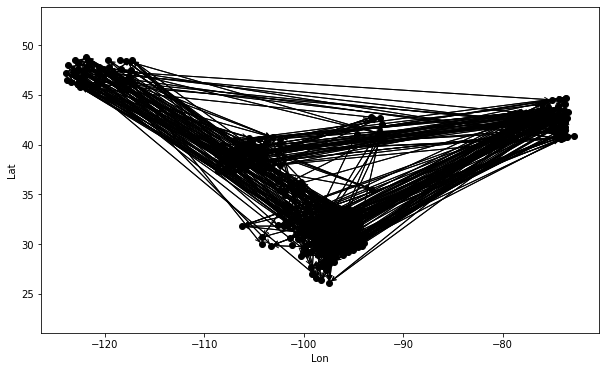

In [138]:
# create a new figure with a bigger size
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

lon_coords = df_plt['county_lon'].to_numpy()
lat_coords = df_plt['county_lat'].to_numpy()
# plot the points
ax.scatter(lon_coords, lat_coords, color='black')

# for i in range(len(lat_coords)):
    
#     ax.scatter(lon_coords[i], lat_coords[i], color=colors[i])
#     #ax.annotate(labels[i], xy=(lon_coords[i], lat_coords[i]), xytext=(lon_coords[i]+0.001, lat_coords[i]+0.001))

troubleshoot = []
# plot the lines between the connected nodes
for connection in activated_arcs:
    x1, y1 = lon_coords[connection[0]], lat_coords[connection[0]]
    x2, y2 = lon_coords[connection[1]], lat_coords[connection[1]]
    dx, dy = x2 - x1, y2 - y1
    troubleshoot.append((connection,dx))
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(facecolor='black', arrowstyle='->'))

# set the axis limits and labels
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.axis('equal')

# display the plot
plt.show()

In [139]:
sorted_tuple = sorted(troubleshoot, key=lambda x: x[1], reverse=True)
sorted_tuple

[((280, 89), 49.03267099999999),
 ((296, 98), 47.87245030000001),
 ((275, 91), 47.58173780000001),
 ((288, 89), 47.58088339999999),
 ((292, 95), 46.476098699999994),
 ((275, 100), 46.3165082),
 ((270, 93), 45.44608814841824),
 ((259, 97), 39.8294317),
 ((40, 56), 33.30370900000001),
 ((35, 60), 33.117912700000005),
 ((35, 87), 33.04122000000001),
 ((42, 71), 33.030964299999994),
 ((35, 70), 32.9198121),
 ((39, 76), 32.82163770000001),
 ((43, 56), 32.39496720000001),
 ((41, 47), 32.3719375),
 ((148, 92), 32.3518239),
 ((39, 82), 32.13248680000001),
 ((40, 68), 32.024282),
 ((35, 59), 31.867903000000013),
 ((43, 82), 31.81293670000001),
 ((43, 63), 31.736291900000012),
 ((33, 75), 31.3461894),
 ((285, 273), 31.020085500000008),
 ((37, 86), 30.774858500000008),
 ((33, 71), 30.315874899999997),
 ((37, 82), 30.284285800000006),
 ((42, 83), 30.243969800000002),
 ((44, 68), 30.231605499999986),
 ((37, 63), 30.20764100000001),
 ((263, 9), 30.156870800000007),
 ((37, 67), 30.069086999999996),
 

In [144]:
conn = [x[0] for x in sorted_tuple if x[1] > 20]
conn

[(280, 89),
 (296, 98),
 (275, 91),
 (288, 89),
 (292, 95),
 (275, 100),
 (270, 93),
 (259, 97),
 (40, 56),
 (35, 60),
 (35, 87),
 (42, 71),
 (35, 70),
 (39, 76),
 (43, 56),
 (41, 47),
 (148, 92),
 (39, 82),
 (40, 68),
 (35, 59),
 (43, 82),
 (43, 63),
 (33, 75),
 (285, 273),
 (37, 86),
 (33, 71),
 (37, 82),
 (42, 83),
 (44, 68),
 (37, 63),
 (263, 9),
 (37, 67),
 (271, 179),
 (42, 51),
 (148, 95),
 (39, 81),
 (44, 80),
 (262, 219),
 (282, 238),
 (43, 81),
 (291, 168),
 (45, 69),
 (278, 179),
 (146, 102),
 (41, 48),
 (33, 74),
 (294, 179),
 (282, 160),
 (271, 251),
 (39, 78),
 (282, 154),
 (176, 92),
 (288, 168),
 (275, 119),
 (272, 175),
 (33, 51),
 (44, 83),
 (287, 127),
 (294, 127),
 (34, 55),
 (176, 99),
 (46, 50),
 (285, 249),
 (287, 256),
 (44, 51),
 (176, 91),
 (45, 65),
 (45, 83),
 (226, 62),
 (122, 98),
 (271, 240),
 (226, 77),
 (291, 151),
 (292, 114),
 (290, 273),
 (278, 133),
 (275, 246),
 (294, 251),
 (280, 253),
 (291, 143),
 (226, 67),
 (275, 142),
 (250, 92),
 (285, 232),

In [146]:
reverse_dic = {value: key for key, value in mapping_dic.items()}
reverse_dic

{0: 8001,
 1: 8005,
 2: 8007,
 3: 8013,
 4: 8014,
 5: 8015,
 6: 8029,
 7: 8031,
 8: 8035,
 9: 8037,
 10: 8041,
 11: 8039,
 12: 8043,
 13: 8045,
 14: 8049,
 15: 8051,
 16: 8059,
 17: 8067,
 18: 8069,
 19: 8075,
 20: 8077,
 21: 8083,
 22: 8085,
 23: 8087,
 24: 8093,
 25: 8097,
 26: 8101,
 27: 8105,
 28: 8107,
 29: 8113,
 30: 8117,
 31: 8119,
 32: 8123,
 33: 36001,
 34: 36003,
 35: 36005,
 36: 36007,
 37: 36011,
 38: 36013,
 39: 36015,
 40: 36017,
 41: 36019,
 42: 36021,
 43: 36023,
 44: 36025,
 45: 36027,
 46: 36029,
 47: 36031,
 48: 36033,
 49: 36035,
 50: 36037,
 51: 36039,
 52: 36043,
 53: 36045,
 54: 36047,
 55: 36051,
 56: 36053,
 57: 36055,
 58: 36057,
 59: 36059,
 60: 36061,
 61: 36063,
 62: 36065,
 63: 36067,
 64: 36069,
 65: 36071,
 66: 36073,
 67: 36075,
 68: 36077,
 69: 36079,
 70: 36081,
 71: 36083,
 72: 36085,
 73: 36087,
 74: 36091,
 75: 36093,
 76: 36097,
 77: 36089,
 78: 36101,
 79: 36103,
 80: 36105,
 81: 36107,
 82: 36109,
 83: 36111,
 84: 36113,
 85: 36115,
 86: 36117,

In [149]:
fip_conn = [(reverse_dic[x[0]], reverse_dic[x[1]]) for x in conn]
fip_conn

[(48241, 48005),
 (48477, 48041),
 (48149, 48021),
 (48373, 48005),
 (48425, 48035),
 (48149, 48055),
 (48013, 48029),
 (48481, 48039),
 (36017, 36053),
 (36005, 36061),
 (36005, 36119),
 (36021, 36083),
 (36005, 36081),
 (36015, 36097),
 (36023, 36053),
 (36019, 36031),
 (48309, 48027),
 (36015, 36109),
 (36017, 36077),
 (36005, 36059),
 (36023, 36109),
 (36023, 36067),
 (36001, 36093),
 (48307, 48083),
 (36011, 36117),
 (36001, 36083),
 (36011, 36109),
 (36021, 36111),
 (36025, 36077),
 (36011, 36067),
 (8065, 8037),
 (36011, 36075),
 (48063, 48499),
 (36021, 36039),
 (48309, 48035),
 (36015, 36107),
 (36025, 36105),
 (8047, 8019),
 (48249, 48131),
 (36023, 36107),
 (48407, 48455),
 (36027, 36079),
 (48223, 48499),
 (48315, 48067),
 (36019, 36033),
 (36001, 36091),
 (48459, 48499),
 (48249, 48409),
 (48063, 48343),
 (36015, 36101),
 (48249, 48355),
 (48491, 48027),
 (48373, 48455),
 (48149, 48177),
 (48077, 48485),
 (36001, 36039),
 (36025, 36111),
 (48365, 48203),
 (48459, 48203),
 

In [148]:
reverse_dic[280]

48241

In [43]:
df_e[df_e['fipscounty'] == 8005]

,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi),Coordinates,county_lat,county_lon
14,"Arapahoe County, CO",8005,"Adams County, CO",8001,Arapahoe County,CO,Adams County,CO,1,16.600485,"(39.6416781, -104.3628567)",39.641678,-104.362857
16,"Arapahoe County, CO",8005,"Denver County, CO",8031,Arapahoe County,CO,Denver County,CO,1,660.426626,"(39.6416781, -104.3628567)",39.641678,-104.362857
17,"Arapahoe County, CO",8005,"Douglas County, CO",8035,Arapahoe County,CO,Douglas County,CO,1,37.441476,"(39.6416781, -104.3628567)",39.641678,-104.362857
18,"Arapahoe County, CO",8005,"Elbert County, CO",8039,Arapahoe County,CO,Elbert County,CO,1,27.001005,"(39.6416781, -104.3628567)",39.641678,-104.362857
19,"Arapahoe County, CO",8005,"Jefferson County, CO",8059,Arapahoe County,CO,Jefferson County,CO,1,47.928654,"(39.6416781, -104.3628567)",39.641678,-104.362857


In [ ]:
# check if all fips values were correctly mapped
# max value should be the len of month df
df_e_idx.max().max()

296

In [ ]:
# list of edge attributes, n_edges x n_edge_attributes
df_e_att = df_e['distance_(mi)']
df_e_att.to_csv('./Data/df_e_att_gnn.csv', index = False)
df_e_att

1        16.600485
2       683.581802
3       649.967579
4        56.499723
5        34.820428
           ...    
2884     48.305737
2885     37.217994
2886     79.821283
2887     81.294253
2888     65.230716
Name: distance_(mi), Length: 1250, dtype: float64

# Adjacency
This code generates the adjacency matrix along with distances for each node pair. I stored these values already and there i sno need to run unless more states are considered.

In [18]:
# state_order = ['CO', 'NY', 'TX', 'WA']
# # drop counties that have nan in state
# df_c.dropna(subset=['state'], inplace=True)
# df_c
# df_c['state'].value_counts()['TX']
# df_a = pd.read_csv('./Data/county_adjacency2010.csv')
# df_a
# df_a[['county','state']] = df_a['countyname'].str.split(', ', expand=True)
# df_a[['neighbor_county', 'neighbor_state']] = df_a['neighborname'].str.split(', ', expand=True)
# df_a = df_a[df_a['state'].isin(state_order)]
# df_a
# # Create a geolocator object
# geolocator = Nominatim(user_agent='my_app')

# # Define a function to calculate distance between two counties
# def calculate_distance(row):
#     # Look up latitude and longitude coordinates for county and neighbor
#     county = geolocator.geocode(row['county'] + ', ' + row['state'] + ', USA')
#     neighbor = geolocator.geocode(row['neighbor_county'] + ', ' + row['neighbor_state'] + ', USA')
#     # Calculate distance using Haversine formula
#     try:
#         distance = geodesic((county.latitude, county.longitude), (neighbor.latitude, neighbor.longitude)).miles
#     except:
#         distance = 0
#     return distance

# # Apply the function to each row of the dataframe
# df_a['distance_(mi)'] = df_a.apply(calculate_distance, axis=1)
# df_a.to_csv('./Data/df_adjacency.csv', index = False)
# df_a
# df_zeros = df_a[df_a['distance_(mi)'] == 0]
# df_zeros.to_csv('./Data/df_zeros.csv', index = False)
# nm_rows = df_a[df_a['neighborname'].str.contains('NM', na=False)]
# len(nm_rows)
# # Create a dataframe that lists all neighboring county pairs
# df_a['count'] = 1
# neighbor_pairs = df_a[['fipscounty', 'fipsneighbor', 'count', 'distance_(mi)']]

# # Create a pivot table with neighboring county names as row and column indices
# adjacency_matrix = df_a.pivot_table(index='fipscounty', columns='fipsneighbor', values='count', fill_value=0)

# # Convert the pivot table to a numpy array to get the adjacency matrix
# distance_matrix = df_a.pivot_table(index='fipscounty', columns='fipsneighbor', values='distance_(mi)', fill_value=0)

KeyboardInterrupt: 

In [19]:
df_a = pd.read_csv('./Data/df_adjacency.csv')
df_a

,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi)
0,"Adams County, CO",8001,"Adams County, CO",8001,Adams County,CO,Adams County,CO,1,0.000000
1,"Adams County, CO",8001,"Arapahoe County, CO",8005,Adams County,CO,Arapahoe County,CO,1,16.600485
2,"Adams County, CO",8001,"Broomfield County, CO",8014,Adams County,CO,Broomfield County,CO,1,683.581802
3,"Adams County, CO",8001,"Denver County, CO",8031,Adams County,CO,Denver County,CO,1,649.967579
4,"Adams County, CO",8001,"Jefferson County, CO",8059,Adams County,CO,Jefferson County,CO,1,56.499723
...,...,...,...,...,...,...,...,...,...,...
2885,"Yakima County, WA",53077,"Klickitat County, WA",53039,Yakima County,WA,Klickitat County,WA,1,37.217994
2886,"Yakima County, WA",53077,"Lewis County, WA",53041,Yakima County,WA,Lewis County,WA,1,79.821283
2887,"Yakima County, WA",53077,"Pierce County, WA",53053,Yakima County,WA,Pierce County,WA,1,81.294253
2888,"Yakima County, WA",53077,"Skamania County, WA",53059,Yakima County,WA,Skamania County,WA,1,65.230716


In [24]:
counties = df_a['countyname'].unique()
coordinates = []
geolocator = Nominatim(user_agent='my_app')
for c in counties:
    county = geolocator.geocode(c + ', USA')
    coordinates.append((county.latitude, county.longitude))


In [28]:
county_coord_map = dict(zip(counties,coordinates))
county_coord_map

{'Adams County, CO': (39.8714085, -104.2701374),
 'Alamosa County, CO': (37.5780995, -105.7890452),
 'Arapahoe County, CO': (39.6416781, -104.3628567),
 'Archuleta County, CO': (37.1995993, -107.0842479),
 'Baca County, CO': (37.3147687, -102.5770885),
 'Bent County, CO': (37.9421152, -103.0964287),
 'Boulder County, CO': (40.102555, -105.3632079),
 'Broomfield County, CO': (35.4764701, -93.0785067),
 'Chaffee County, CO': (38.7413025, -106.1825012),
 'Cheyenne County, CO': (38.8307233, -102.6177692),
 'Clear Creek County, CO': (39.6754591, -105.6435349),
 'Conejos County, CO': (37.1851939, -106.1655431),
 'Costilla County, CO': (37.2367948, -105.4182008),
 'Crowley County, CO': (38.3394806, -103.8263042),
 'Custer County, CO': (38.1072962, -105.3543375),
 'Delta County, CO': (38.8368777, -107.8568294),
 'Denver County, CO': (42.6713752, -92.3372158),
 'Dolores County, CO': (37.7524811, -108.4596087),
 'Douglas County, CO': (39.3420437, -104.9468945),
 'Eagle County, CO': (39.6161124, 

In [50]:
df_a['Coordinates'] = df_a['countyname'].map(county_coord_map)
df_a[['county_lat', 'county_lon']] = df_a['Coordinates'].apply(pd.Series)

len(df_a['countyname'].unique())

419

In [32]:
df_a.to_csv('./Data/df_adjacency.csv', index = False)

In [27]:
pairs = df_a[['countyname','fipscounty']].drop_duplicates()
pairs.head()

,countyname,fipscounty
0,"Adams County, CO",8001
8,"Alamosa County, CO",8003
14,"Arapahoe County, CO",8005
22,"Archuleta County, CO",8007
30,"Baca County, CO",8009


In [25]:
fips = df_a.loc[df['fipscounty']]

[(39.8714085, -104.2701374),
 (37.5780995, -105.7890452),
 (39.6416781, -104.3628567),
 (37.1995993, -107.0842479),
 (37.3147687, -102.5770885),
 (37.9421152, -103.0964287),
 (40.102555, -105.3632079),
 (35.4764701, -93.0785067),
 (38.7413025, -106.1825012),
 (38.8307233, -102.6177692),
 (39.6754591, -105.6435349),
 (37.1851939, -106.1655431),
 (37.2367948, -105.4182008),
 (38.3394806, -103.8263042),
 (38.1072962, -105.3543375),
 (38.8368777, -107.8568294),
 (42.6713752, -92.3372158),
 (37.7524811, -108.4596087),
 (39.3420437, -104.9468945),
 (39.6161124, -106.7172844),
 (39.3138822, -104.0868973),
 (38.8287435, -104.5253456),
 (38.4692006, -105.4328622),
 (39.5462048, -107.8776144),
 (39.8586654, -105.5025219),
 (40.0990074, -106.1366966),
 (38.6476702, -107.0603126),
 (37.813681, -107.3304179),
 (37.7013983, -105.0218531),
 (40.6531945, -106.3447246),
 (39.5699803, -105.2561919),
 (38.4411214, -102.7628476),
 (39.3080613, -102.62075),
 (39.2056525, -106.342801),
 (37.2889732, -107.85

In [ ]:
# Define a function to calculate distance between two counties
def calculate_distance(row):
    # Look up latitude and longitude coordinates for county and neighbor
    county = geolocator.geocode(row['county'] + ', ' + row['state'] + ', USA')
    neighbor = geolocator.geocode(row['neighbor_county'] + ', ' + row['neighbor_state'] + ', USA')
    # Calculate distance using Haversine formula
    try:
        distance = geodesic((county.latitude, county.longitude), (neighbor.latitude, neighbor.longitude)).miles
    except:
        distance = 0
    return distance